# <center style="color:#FF9009">McDonald's Case Study</center>

### <span style="color:#EBBC29">Loading Libraries and Data<span>

In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from bioinfokit.visuz import cluster
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier, plot_tree


mcdonalds = pd.read_csv('mcdonalds.csv')
print("Features - ",list(mcdonalds.columns))
print("\nShape -",mcdonalds.shape, "\n")
mcdonalds.head(3)

Features -  ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']

Shape - (1453, 15) 



,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


### <span style="color:#EBBC29">Data Transformation<span>

In [185]:
# Extracting first 11 columns because these columns contain segmentation variables
df = mcdonalds.iloc[:, 0:11]
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No


In [186]:
# Encoding Yes to 1 & No to 0
df = (df == "Yes").astype(int)
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0


### <span style="color:#EBBC23">Data Cleaning & Preprocessing</span>

In [187]:
# Checking Null Data
df.isnull().sum()

yummy         0
convenient    0
spicy         0
fattening     0
greasy        0
fast          0
cheap         0
tasty         0
expensive     0
healthy       0
disgusting    0
dtype: int64

In [188]:
# Checking Duplicate Data
df.duplicated().sum()

1189

### <span style="color:#EBBC23">Exploratory Data Analysis</span>

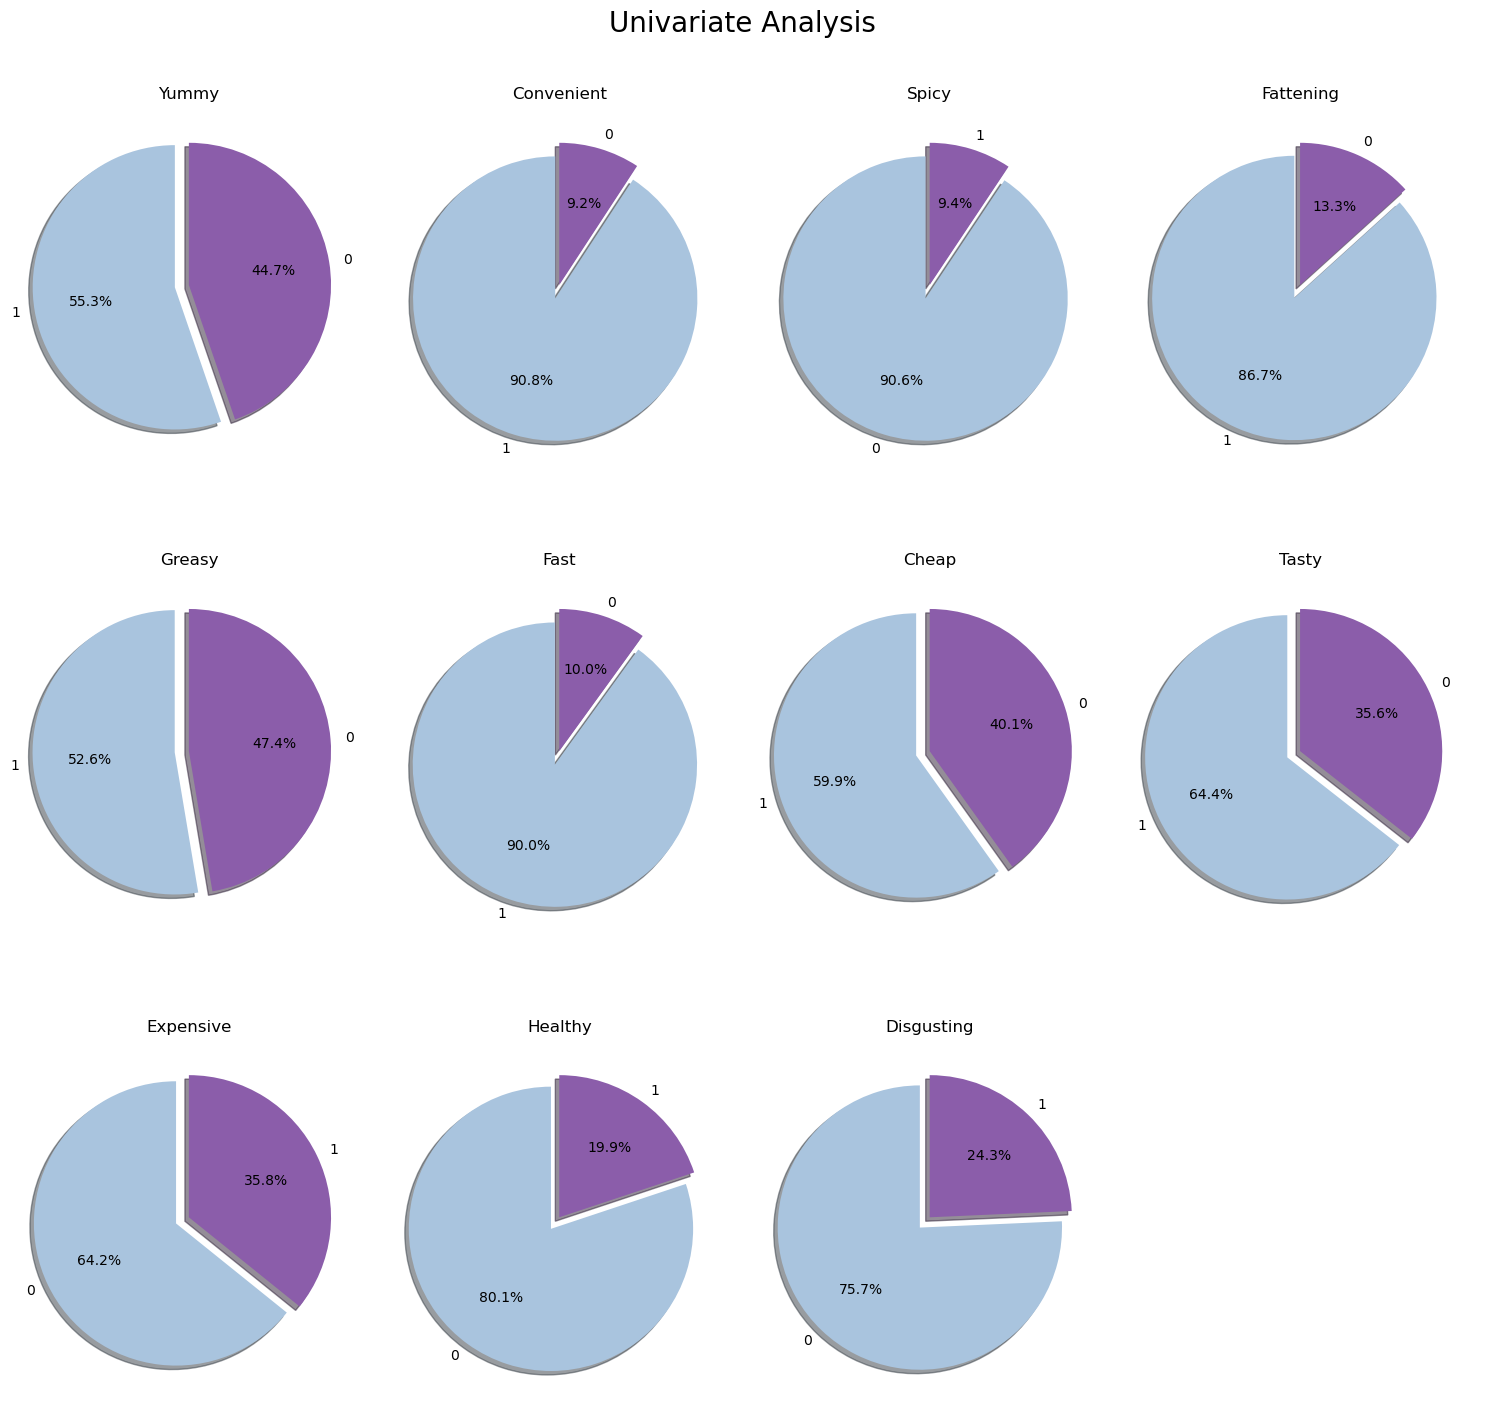

In [189]:
# Univariate Analysis
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 15))
ax = ax.flatten()

for i, feature in enumerate(df.columns):
    counts = df[feature].value_counts()
    ax[i].pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        colors=sns.color_palette('BuPu', len(counts)), 
        explode=(0.1, 0), 
        shadow=True, 
        startangle=90
        )
    
    ax[i].set_title(str.capitalize(feature))

# Remove unused subplots
for ax_ in ax[len(df.columns):]:
    fig.delaxes(ax_)
    
fig.suptitle('Univariate Analysis', size=20)
plt.tight_layout()
plt.show()

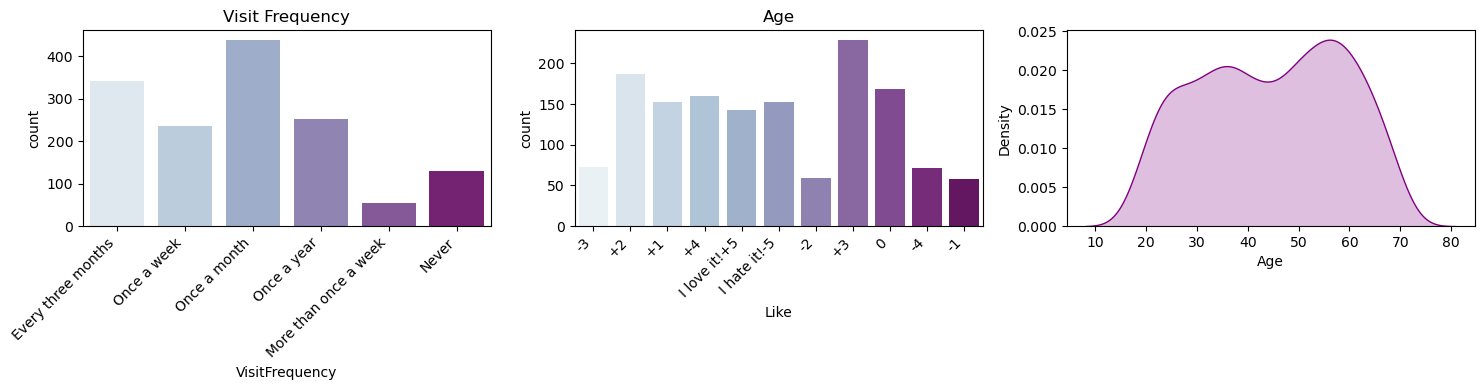

In [190]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

sns.countplot(data=mcdonalds, x='VisitFrequency', palette='BuPu', ax=ax[0])
ax[0].set_title("Visit Frequency")
plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right')

sns.countplot(data=mcdonalds, x='Like', palette='BuPu', ax=ax[1])
ax[1].set_title("Like")
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')

sns.kdeplot(data=mcdonalds, x='Age', color='purple', ax=ax[2], fill=True)
ax[1].set_title("Age")

plt.tight_layout()
plt.show()

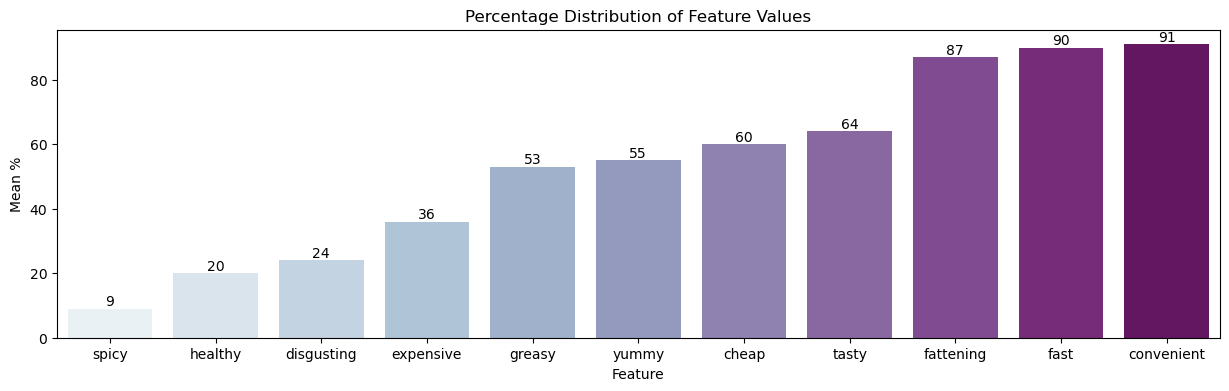

In [191]:
# Finding where, most of data lies
mean_percentage = (df.mean().round(2)*100).astype(int)
mean_percentage = mean_percentage.reset_index().rename(columns={"index":"Feature", 0:"Mean %"})

plt.figure(figsize=(15,4))
ax = sns.barplot(data=mean_percentage.sort_values(by='Mean %'), x='Feature', y='Mean %', palette='BuPu', )
ax.bar_label(ax.containers[0])
plt.title("Percentage Distribution of Feature Values")
plt.show()

People Find McDonald's food -
* 91% convenient 
* 55% yummy & 
* 9% spicy

### <span style="color:#EBBC23">Principal Component Analysis (PCA)</span>

In [192]:
pca = PCA()
pc = pca.fit_transform(df)
df_pca = pd.DataFrame(pca.components_, columns=df.columns).round(3).T
df_pca.columns = [f"PC{i}" for i in range(1,12)]
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,-0.477,0.364,-0.304,0.055,-0.308,0.171,-0.281,0.013,0.572,-0.110,0.045
convenient,-0.155,0.016,-0.063,-0.142,0.278,-0.348,-0.060,-0.113,-0.018,-0.666,-0.542
spicy,-0.006,0.019,-0.037,0.198,0.071,-0.355,0.708,0.376,0.400,-0.076,0.142
fattening,0.116,-0.034,-0.322,-0.354,-0.073,-0.407,-0.386,0.590,-0.161,-0.005,0.251
greasy,0.304,-0.064,-0.802,0.254,0.361,0.209,0.036,-0.138,-0.003,0.009,0.002
fast,-0.108,-0.087,-0.065,-0.097,0.108,-0.595,-0.087,-0.628,0.166,0.240,0.339
cheap,-0.337,-0.611,-0.149,0.119,-0.129,-0.103,-0.040,0.140,0.076,0.428,-0.489
tasty,-0.472,0.307,-0.287,-0.003,-0.211,-0.077,0.360,-0.073,-0.639,0.079,0.020
expensive,0.329,0.601,0.024,0.068,-0.003,-0.261,-0.068,0.030,0.067,0.454,-0.490
healthy,-0.214,0.077,0.192,0.763,0.288,-0.178,-0.350,0.176,-0.186,-0.038,0.158


In [193]:
# Calculate the proportion of variance, standard deviation and cummulative variance explained by each principal component
standard_deviation = np.sqrt(pca.explained_variance_)
proportion_variance = pca.explained_variance_ratio_
cummulative_variance = proportion_variance.cumsum()

summary = pd.DataFrame(
    {"Standard deviation": standard_deviation,
    "Proportion of Variance": proportion_variance,
    "Cumulative Proportion": cummulative_variance}, 
    index=[f"PC{i}" for i in range(1, 12)]
    )

summary

,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,0.757050,0.299447,0.299447
PC2,0.607456,0.192797,0.492244
PC3,0.504619,0.133045,0.625290
PC4,0.398799,0.083096,0.708386
PC5,0.337405,0.059481,0.767866
PC6,0.310275,0.050300,0.818166
PC7,0.289697,0.043849,0.862015
PC8,0.275122,0.039548,0.901563
PC9,0.265251,0.036761,0.938323
PC10,0.248842,0.032353,0.970677


Conclusion - **Results from principal components analysis indicate that the first two components
capture about 50% (49.05%) of the information contained in the segmentation variables**

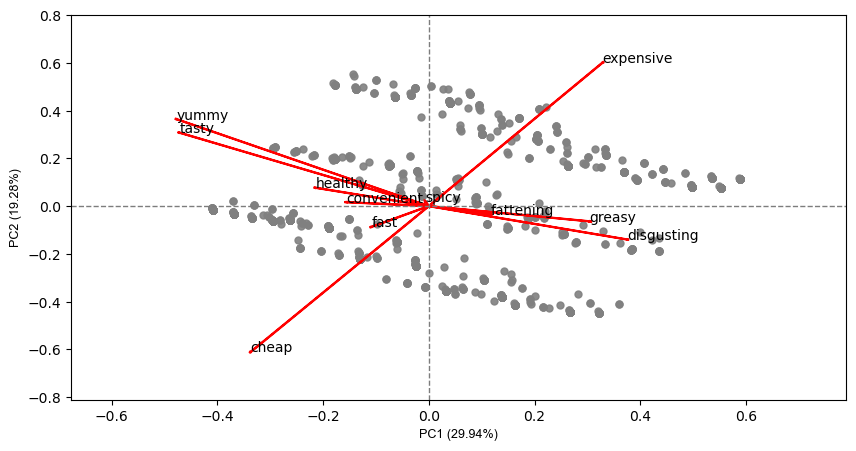

In [194]:
# Principal components analysis of the fast food data set
cluster.biplot(cscore=pc, loadings=pca.components_, labels=df.columns, 
               var1=round(pca.explained_variance_ratio_[0]*100, 2),
               var2=round(pca.explained_variance_ratio_[1]*100, 2),
               show=True, dim=(10, 5), markerdot='o', dotsize=25, valphadot=0.9, colordot='Grey', 
               arrowcolor='red', valphaarrow=1, arrowlinestyle='-', arrowlinewidth=1.5)

CHEAP and EXPENSIVE attribute play a key role in the evaluation of McDonald’s, and these two attributes are assessed quite independently of the others. The remaining attributes align with what can be interpreted as positive versus negative perceptions: FATTENING, DISGUSTING and GREASY point in the same direction in the perceptual chart, indicating that respondents who view McDonald’s as FATTENING, DISGUSTING are also likely to view it as GREASY. In the opposite direction are the positive attributes FAST, CONVENIENT, HEALTHY, as well as TASTY and YUMMY.

### <span style="color:#EBBC23">K-Means CLustering</span>

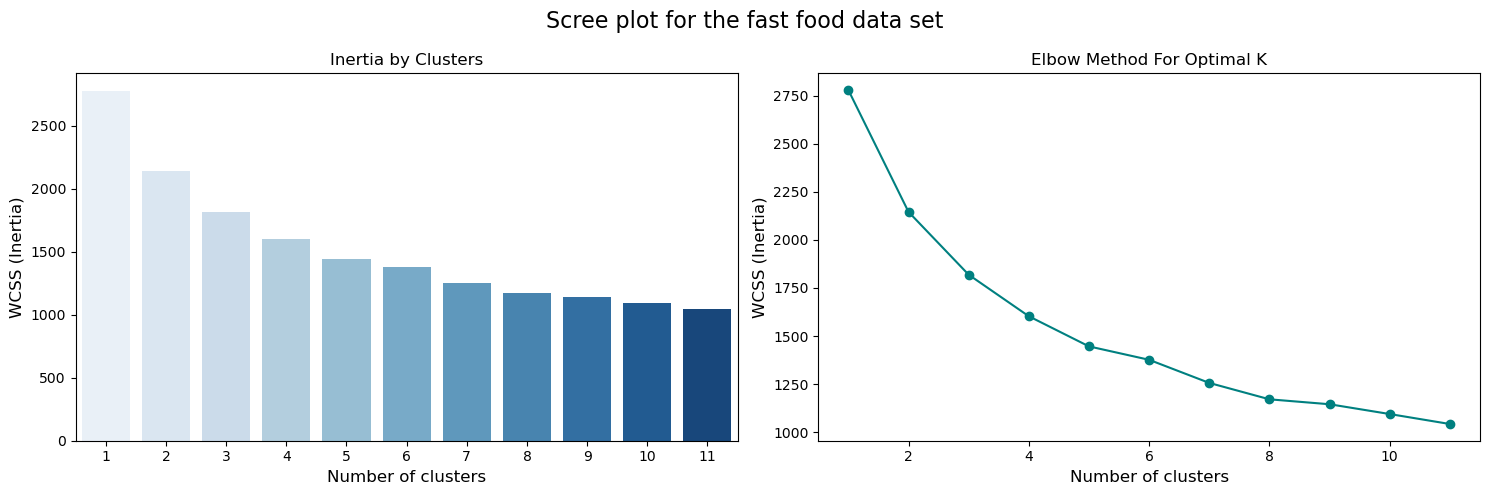

In [195]:
# performing clustering for cluster range 1 to 12 
K = range(1,12)
wcss = []

for i in K:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

wcss_df = pd.DataFrame({"Clusters":K, "Inertia":wcss})

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  

sns.barplot(ax=axs[0], data=wcss_df, x='Clusters', y='Inertia', palette='Blues')
axs[0].set_xlabel('Number of clusters', fontsize=12)
axs[0].set_ylabel('WCSS (Inertia)', fontsize=12)
axs[0].set_title('Inertia by Clusters', fontsize=12)

axs[1].plot(K, wcss, marker='o', color='teal')
axs[1].set_xlabel('Number of clusters', fontsize=12)
axs[1].set_ylabel('WCSS (Inertia)', fontsize=12)
axs[1].set_title('Elbow Method For Optimal K', fontsize=12)

plt.suptitle('Scree plot for the fast food data set', fontsize=16)
plt.tight_layout()
plt.show()

**Note** - Scree plots are unreliable for market segmentation, because it does not have a distinct elbow. This means that the sum of distances within market segments drops slowly with increase in market segments.

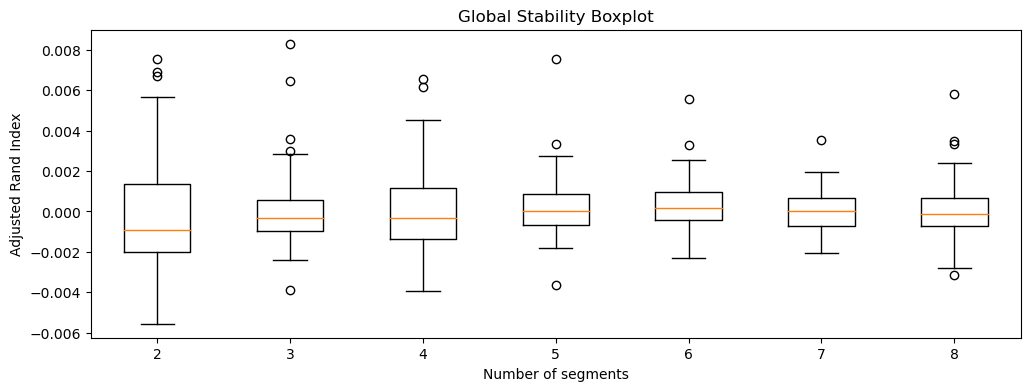

In [196]:
def bootstrap_stability(data, n_clusters, n_boot=100, n_rep=10):
    stability_scores = []

    for _ in range(n_boot):
        sample = resample(data)
        model = KMeans(n_clusters=n_clusters, n_init=n_rep, random_state=1234)
        model.fit(sample)
        labels = model.predict(data)
        stability = adjusted_rand_score(model.labels_, labels)
        stability_scores.append(stability)

    return stability_scores


n_segments = range(2, 9)
stability_results = {k: bootstrap_stability(df, k) for k in n_segments}


fig, ax = plt.subplots(figsize=(12,4))
ax.boxplot([stability_results[k] for k in n_segments], labels=n_segments)
ax.set_xlabel('Number of segments')
ax.set_ylabel('Adjusted Rand Index')
ax.set_title('Global Stability Boxplot')
plt.show()


**Note** - Stability analysis is a better approach to determine optimal market segments.

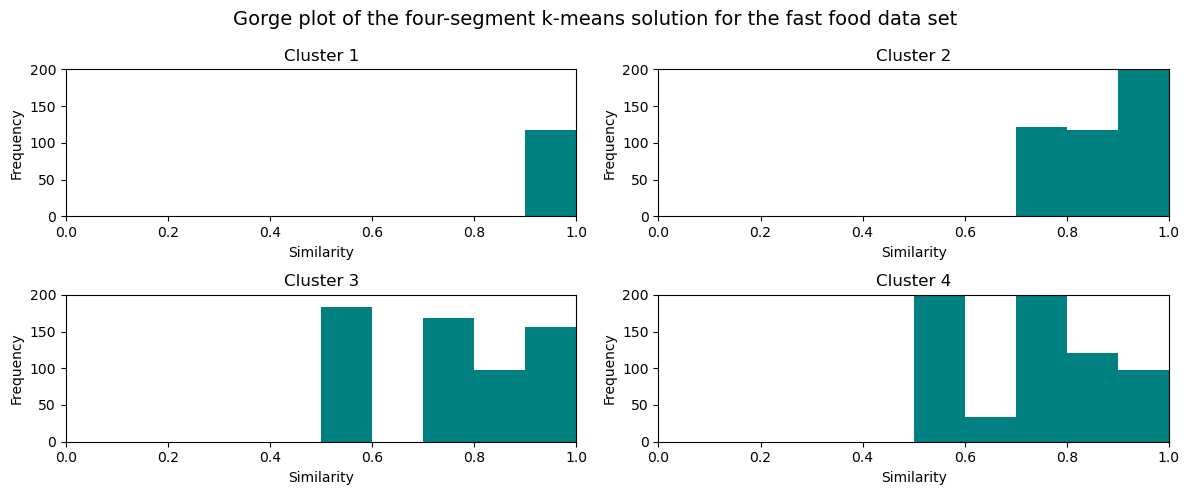

In [197]:
kmeans_data = {}
K = range(1,12)

for i in K:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df)
    kmeans_data[str(i)] = kmeans

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

for i in range(1, 5):
    similarities = kmeans_data[str(i)].transform(df).min(axis=1)
    row = (i - 1) // 2
    col = (i - 1) % 2

    axs[row, col].hist(similarities, bins=10, range=(0,1), color='teal')
    axs[row, col].set_xlabel('Similarity')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title('Cluster {}'.format(i), size=12)
    axs[row, col].set_xlim(0, 1)
    axs[row, col].set_ylim(0, 200)
    axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])


fig.suptitle("Gorge plot of the four-segment k-means solution for the fast food data set", size=14)
plt.tight_layout()
plt.show()

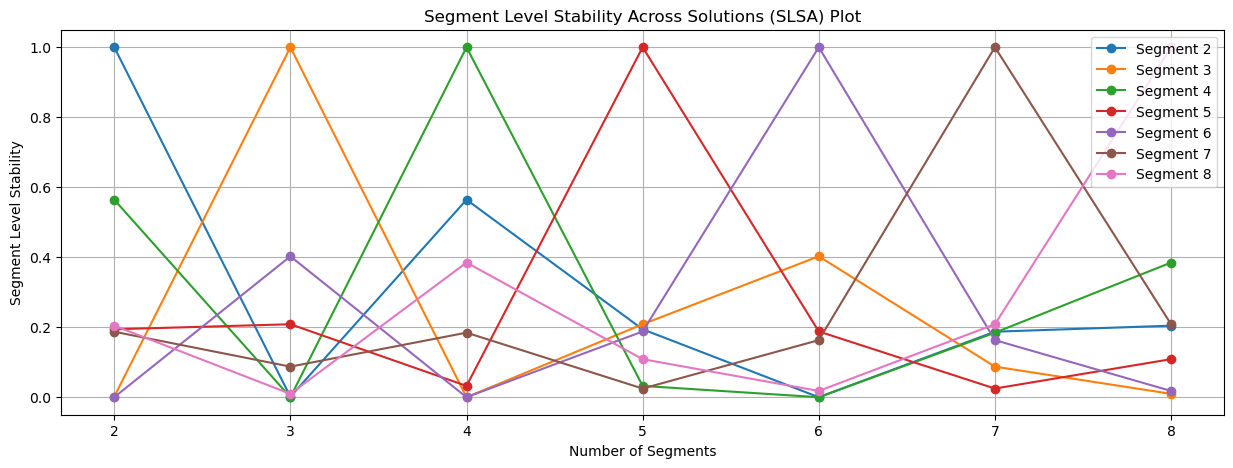

In [198]:
num_segments = range(2, 9)

segment_stability = []
for i in range(2, 9):
    labels_segment = kmeans_data[str(i)].predict(df)
    segment_stability.append(labels_segment)

plt.figure(figsize=(15, 5))
for i, segment in enumerate(range(2, 9)):
    plt.plot(num_segments, [np.mean(segment_stability[i] == labels) for labels in segment_stability], marker='o', label=f'Segment {segment}')


plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)
plt.show()

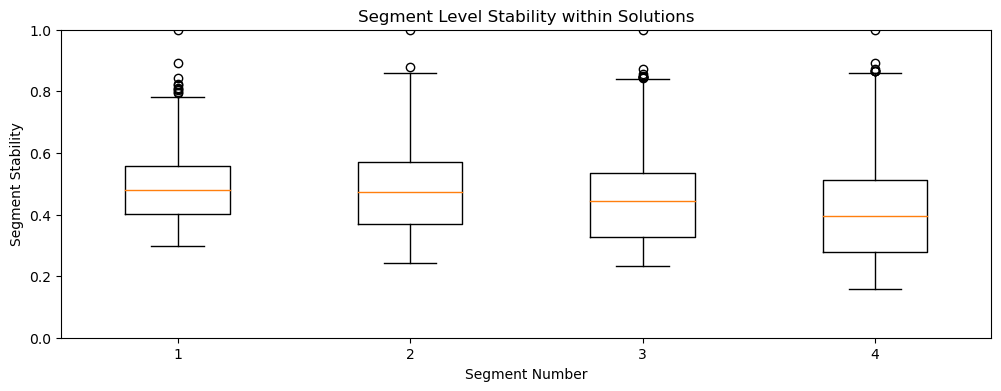

In [199]:
segment_labels = {}
segment_similarities = {}

for i in range(2,6):
    segment_labels[str(i)] = kmeans_data[str(i)].predict(df)
    segment_similarities[str(i)] = kmeans_data[str(i)].transform(df).min(axis=1)

segment_stability_values = []
for i in range(2,6):
    similarities = segment_similarities[str(i)]
    normalized_similarities = similarities / np.max(similarities) 
    segment_stability_values.append(normalized_similarities)


plt.figure(figsize=(12,4))
plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, 5))
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")
plt.show()

In [200]:
from scipy.stats import entropy

np.random.seed(1234)
k_values = range(2, 9)
kmeans_new_data = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234, n_init='auto')
    model.fit(df.values)
    iter_val = model.n_iter_
    converged = True
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = df.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy
    
    kmeans_new_data.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))
kmeans_new_data = pd.DataFrame(kmeans_new_data, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(kmeans_new_data)

   iter  converged  k  k0       logLik          AIC          BIC          ICL
0    10       True  2   2 -2146.062044  4296.124088  4306.686859  4306.015908
1     5       True  3   3 -1896.330266  3798.660532  3814.504689  3813.529671
2     9       True  4   4 -1603.913802  3215.827604  3236.953147  3235.627738
3     9       True  5   5 -1502.697153  3015.394306  3041.801234  3040.267284
4     7       True  6   6 -1348.665399  2709.330799  2741.019113  2739.277954
5    10       True  7   7 -1249.233890  2512.467780  2549.437480  2547.530062
6     9       True  8   8 -1203.646165  2423.292330  2465.543415  2463.533662


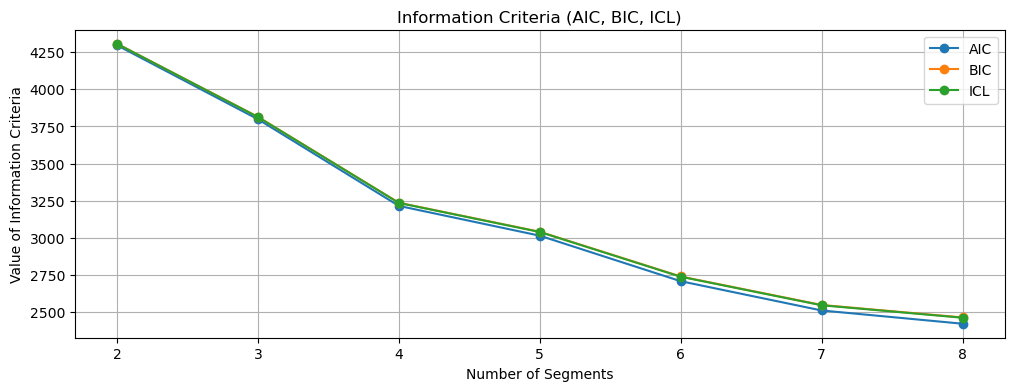

In [201]:
num_segments = kmeans_new_data["k"]
AIC_values = kmeans_new_data["AIC"]
BIC_values = kmeans_new_data["BIC"]
ICL_values = kmeans_new_data["ICL"]

plt.figure(figsize=(12,4))
plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')
plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)
plt.show()

In [202]:
# Contingency Table
kmeans = KMeans(n_clusters=4, random_state=1234, n_init='auto')
kmeans.fit(df)
kmeans_clusters = kmeans.predict(df)

gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(df)
gmm_clusters = gmm.predict(df)

results = pd.DataFrame({'kmeans': kmeans_clusters, 'mixture': gmm_clusters})

print("Contingency Table:")
contingency_table = pd.crosstab(results['kmeans'], results['mixture'])
contingency_table

Contingency Table:


mixture,0,1,2,3
kmeans,,,,
0,546,0,1,33
1,0,213,11,4
2,46,3,265,8
3,29,38,0,256


In [203]:
gm = GaussianMixture(n_components=4)
gm.fit(df)
log_likelihood_m4a = gm.score(df)

gm = GaussianMixture(n_components=4)
gm.fit(df)
log_likelihood_m4 = gm.score(df)

print("Log-likelihood for MD.m4a:", log_likelihood_m4a)
print("Log-likelihood for MD.m4:", log_likelihood_m4)

Log-likelihood for MD.m4a: 9.456781748071887
Log-likelihood for MD.m4: 3.6427464011765807


In [204]:
mcdonalds['Like'].value_counts().reset_index().sort_values(by='count', ascending=False)

,Like,count
0,+3,229
1,+2,187
2,0,169
3,+4,160
4,+1,152
5,I hate it!-5,152
6,I love it!+5,143
7,-3,73
8,-4,71
9,-2,59


In [205]:
# Define a mapping of string values to numeric codes
like_mapping = {
    'I hate it!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '+2': 2,
    '+3': 3,
    '+4': 4,
    'I love it!+5': 5
}

mcdonalds['Like'] = mcdonalds['Like'].map(like_mapping)
mcdonalds['Like'].value_counts()

Like
 3.0    229
 2.0    187
 0.0    169
 4.0    160
-5.0    152
 5.0    143
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64

In [206]:
from patsy import dmatrices, dmatrix

independent_vars = mcdonalds.columns[0:11] 
formula_str = 'Like ~ ' + ' + '.join(independent_vars)
f = dmatrices(formula_str, data=mcdonalds)[1]

print(f)

[[1. 0. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]]


In [207]:
np.random.seed(1234)

X = dmatrix(f.design_info, data=mcdonalds)
y = dmatrix('Like', data=mcdonalds)

n_components = 2
n_init = 10
verbose = False
n_rep=10

model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)
reg_model = model.fit(X, y)

print(reg_model)
cluster_sizes = np.bincount(model.predict(X))

print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"{i+1}: {size}")


GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
1: 985
2: 468


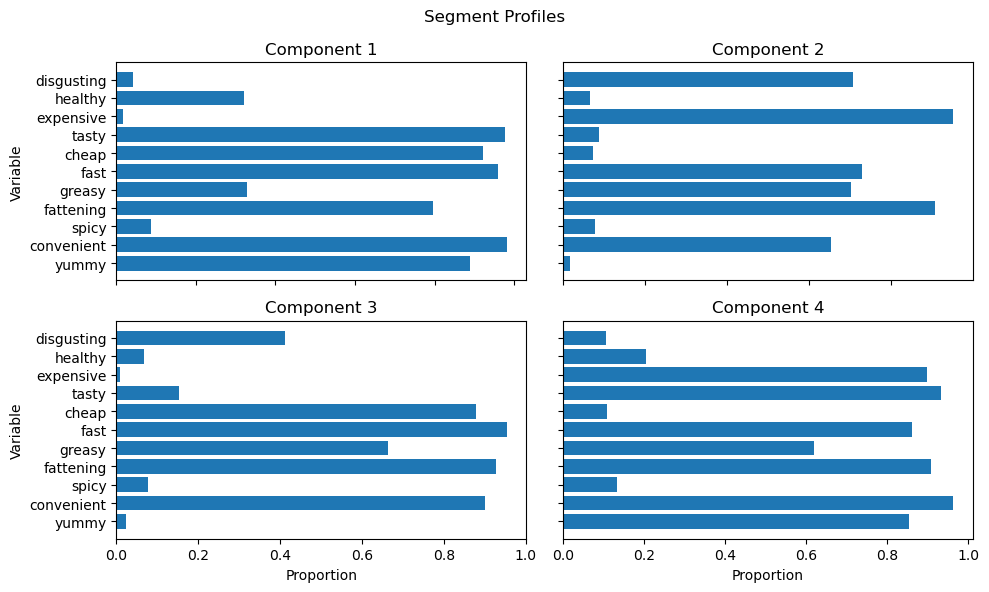

In [208]:
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=1234)
kmeans.fit(df)

labels = kmeans.labels_

df_mean = df.groupby(labels).mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].barh(range(df_mean.shape[1]), df_mean.iloc[0])
axs[0, 0].set_title('Component 1')
axs[0, 1].barh(range(df_mean.shape[1]), df_mean.iloc[1])
axs[0, 1].set_title('Component 2')
axs[1, 0].barh(range(df_mean.shape[1]), df_mean.iloc[2])
axs[1, 0].set_title('Component 3')
axs[1, 1].barh(range(df_mean.shape[1]), df_mean.iloc[3])
axs[1, 1].set_title('Component 4')

for ax in axs.flat:
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(df_mean.shape[1]))
    ax.set_yticklabels(df.columns)

for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Segment Profiles')
fig.tight_layout()
plt.show()

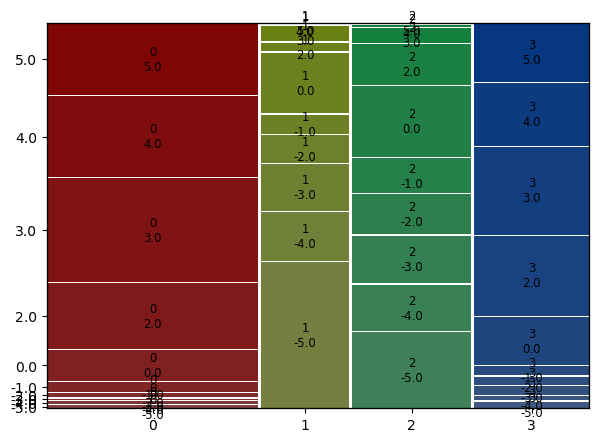

In [209]:
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from sklearn.preprocessing import LabelEncoder

def labelling(x):
    mcdonalds[x] = LabelEncoder().fit_transform(mcdonalds[x])
    return mcdonalds

cat = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap','tasty', 'expensive', 'healthy', 'disgusting']

for i in cat:
    labelling(i)

df_eleven = mcdonalds.loc[:,cat]

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=1234, n_init='auto').fit(df_eleven)
mcdonalds['cluster_num'] = kmeans.labels_ 
crosstab =pd.crosstab(mcdonalds['cluster_num'],mcdonalds['Like'])
crosstab = crosstab[[-5,-4,-3,-2,-1,0,2,3,4,5]]
plt.rcParams['figure.figsize'] = (7,5)
mosaic(crosstab.stack())
plt.show()


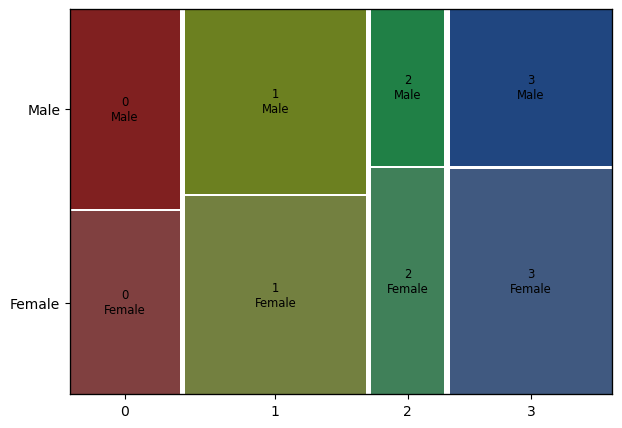

In [210]:
from statsmodels.graphics.mosaicplot import mosaic

kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(df)

ct = pd.crosstab(kmeans.labels_, mcdonalds['Gender'])
mosaic(ct.stack(),gap=0.01)

plt.show()

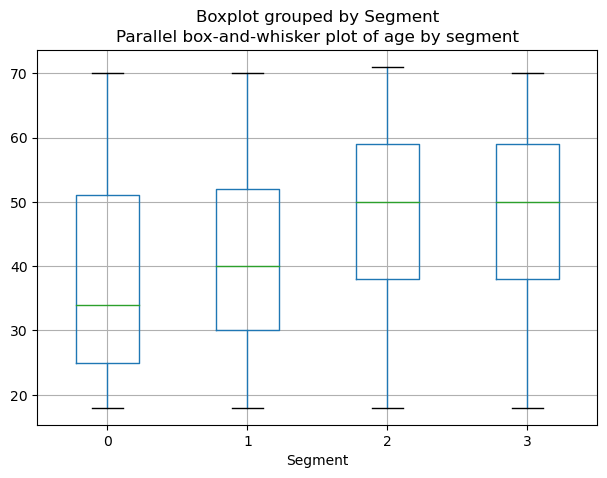

In [211]:
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(df)
df = pd.DataFrame({'Segment': kmeans.labels_, 'Age': mcdonalds['Age']})

df.boxplot(by='Segment', column='Age')
plt.title('Parallel box-and-whisker plot of age by segment')
plt.show()

In [213]:
mcdonalds['VisitFrequency'] = LabelEncoder().fit_transform(mcdonalds['VisitFrequency'])
visit = mcdonalds.groupby('cluster_num')['VisitFrequency'].mean()
visit = visit.to_frame().reset_index()
visit

,cluster_num,VisitFrequency
0,0,2.584483
1,1,2.671053
2,2,2.801242
3,3,2.547988


In [ ]:
mcdonalds['Like'] = LabelEncoder().fit_transform(mcdonalds['Like'])
Like = mcdonalds.groupby('cluster_num')['Like'].mean()
Like = Like.to_frame().reset_index()
Like

,cluster_num,Like
0,0,7.350000
1,1,2.508772
2,2,3.698758
3,3,6.987616


In [ ]:
mcdonalds['Gender'] = LabelEncoder().fit_transform(mcdonalds['Gender'])
Gender = mcdonalds.groupby('cluster_num')['Gender'].mean()
Gender = Gender.to_frame().reset_index()
Gender

,cluster_num,Gender
0,0,0.398276
1,1,0.578947
2,2,0.413043
3,3,0.523220


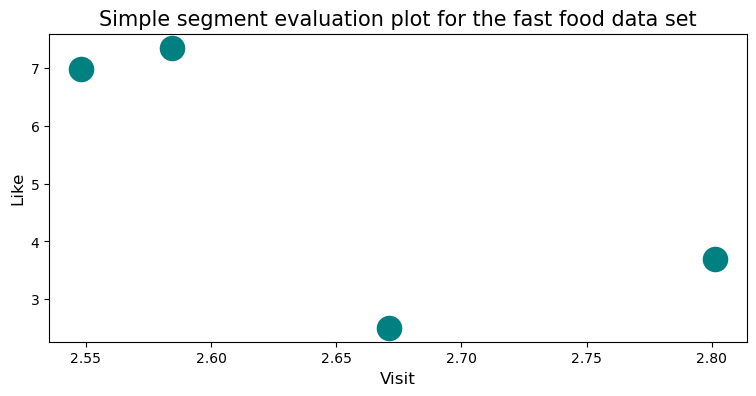

In [215]:
segment = Gender.merge(Like, on='cluster_num', how='left').merge(visit, on='cluster_num', how='left')
plt.figure(figsize = (9,4))
sns.scatterplot(x = "VisitFrequency", y = "Like",data=segment,s=400, color="teal")
plt.title("Simple segment evaluation plot for the fast food data set",fontsize = 15) 
plt.xlabel("Visit", fontsize = 12) 
plt.ylabel("Like", fontsize = 12) 
plt.show()